# Projet : Clustering avec K-means et ses variantes (MAGIC Gamma Telescope)

### Objectif
L’objectif de ce travail est de pratiquer l’analyse de données et le clustering
à travers le jeu de données **MAGIC Gamma Telescope** (UCI).
Il s’agit de comparer différentes variantes de **K-means** en fonction
des caractéristiques du jeu de données, d’évaluer leurs performances
avec des métriques internes (sans labels), puis de compléter l’analyse
par des métriques externes (avec labels disponibles).
Enfin, on étudiera l’effet de la réduction de dimension (PCA) sur les résultats.

### Tâches à réaliser
1. **Étudier les données**  

2. **Analyser les variantes de K-means** (scikit-learn)  

3. **Choisir une variante adaptée**  

4. **Comparer avec K-means standard**  

5. **Étudier l’effet d’une réduction de dimension (PCA)**  

## 1) Étude des données

Nous utilisons le jeu de données **MAGIC Gamma Telescope** (UCI).  
Il provient de simulations Monte Carlo (programme *CORSIKA*) d’un télescope Cherenkov atmosphérique au sol (MAGIC).  
Le télescope observe les gerbes atmosphériques produites par des particules gamma de haute énergie.  
Ces gerbes créent une **tache lumineuse allongée** sur le plan de la caméra.  
Après prétraitement, cette tache est approximée par une **ellipse** grâce à une ACP (PCA).  
On en extrait un ensemble de paramètres géométriques et d’intensité appelés **Hillas parameters**.

Ces paramètres permettent de distinguer deux types d’événements :  
- **gamma (signal)** : cascades électromagnétiques produites par les rayons gamma,  
- **hadron (bruit de fond)** : cascades hadroniques produites par des rayons cosmiques.

### Caractéristiques principales
- **Nombre d’instances** : 19 020  
- **Nombre de variables** : 10 (toutes continues, aucune valeur manquante)  
- **Classes** : deux catégories  
  - `g = gamma (signal)` : 12 332 (~64,8 %)  
  - `h = hadron (bruit de fond)` : 6 688 (~35,2 %)  
  Dans les vraies données, les hadrons devraient être majoritaires → ils sont sous-estimés ici.  

Pour le clustering non supervisé, **les labels ne seront pas utilisés**.  
Ils serviront uniquement à l’**évaluation externe** (pureté, ARI, NMI).

### Variables (features)

1. **fLength** : axe majeur de l’ellipse (mm) – reflète l’allongement de la tache lumineuse.  
2. **fWidth** : axe mineur de l’ellipse (mm) – reflète la largeur de la tache.  
3. **fSize** : log (base 10) de la somme des intensités (# photons) – correspond à la luminosité totale.  
4. **fConc** : deux pixels les plus brillants / fSize – mesure la concentration de la lumière.  
5. **fConc1** : pixel le plus brillant / fSize – concentration sur un seul pixel.  
6. **fAsym** : distance du pixel le plus lumineux au centre sur l’axe majeur – indique l’asymétrie de l’image.  
7. **fM3Long** : racine cubique du 3ᵉ moment le long de l’axe majeur – caractérise la distribution sur la longueur.  
8. **fM3Trans** : racine cubique du 3ᵉ moment le long de l’axe mineur – caractérise la distribution sur la largeur.  
9. **fAlpha** :angle entre l’axe majeur et le vecteur vers l’origine (°) – indique l’orientation de la tache.  
10. **fDist** :distance entre l’origine (centre caméra) et le centre de l’ellipse (mm) – indique la position de l’événement dans le champ de vision.



### Chargement les donnees

In [37]:
# --- Imports de base ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Chargement des données UCI ---
cols = ["fLength","fWidth","fSize","fConc","fConc1","fAsym",
        "fM3Long","fM3Trans","fAlpha","fDist","class"]
df = pd.read_csv("magic04.data", header=None, names=cols)

# Séparation X / y (y non utilisé ici, réservé pour Q4)
X = df.drop(columns=["class"]).values
y = df["class"].values

# --- Mise à l’échelle (indispensable pour K-means) ---
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print(df.shape, " | Aucune valeur manquante:", not df.isna().any().any())

(19020, 11)  | Aucune valeur manquante: True


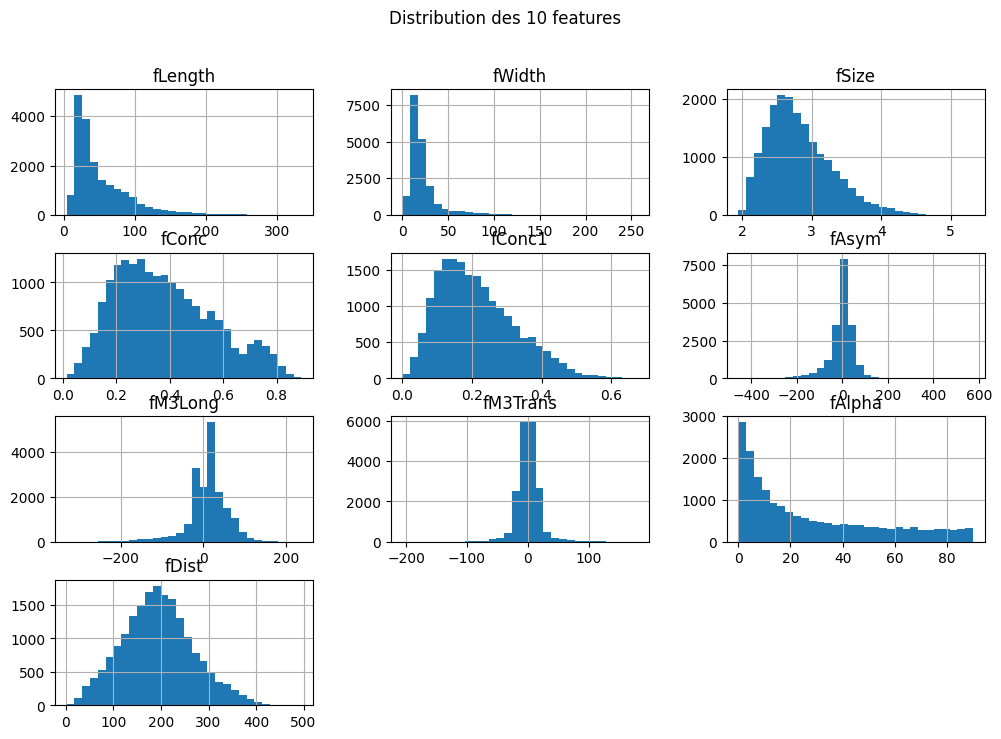

In [38]:
import matplotlib.pyplot as plt
df.drop(columns="class").hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution des 10 features")
plt.show()

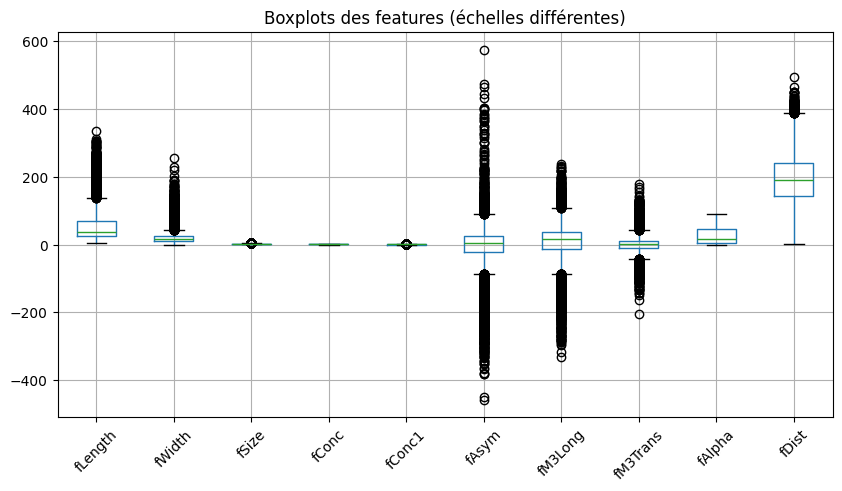

In [39]:
plt.figure(figsize=(10,5))
df.drop(columns="class").boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots des features (échelles différentes)")
plt.show()

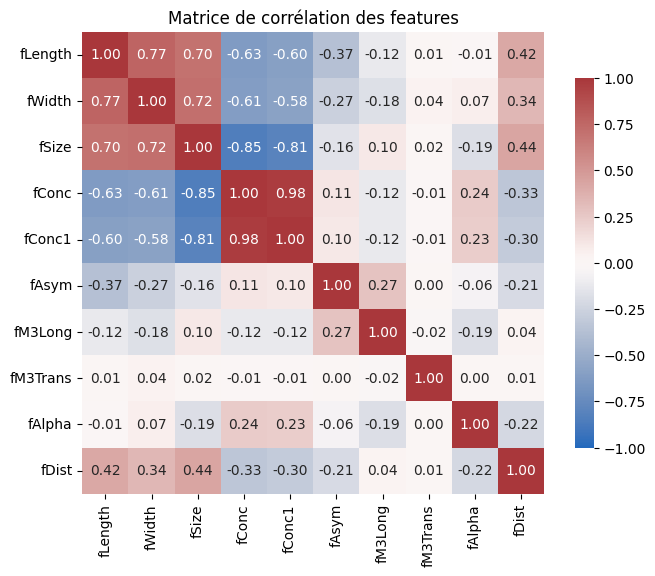

In [40]:
import seaborn as sns
plt.figure(figsize=(8,6))
corr = df.drop(columns="class").corr()
#sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
sns.heatmap(
    corr, vmin=-1, vmax=1, cmap="vlag", annot=True, fmt=".2f",
    square=True, cbar_kws={"shrink": .8}
)
plt.title("Matrice de corrélation des features")
plt.show()


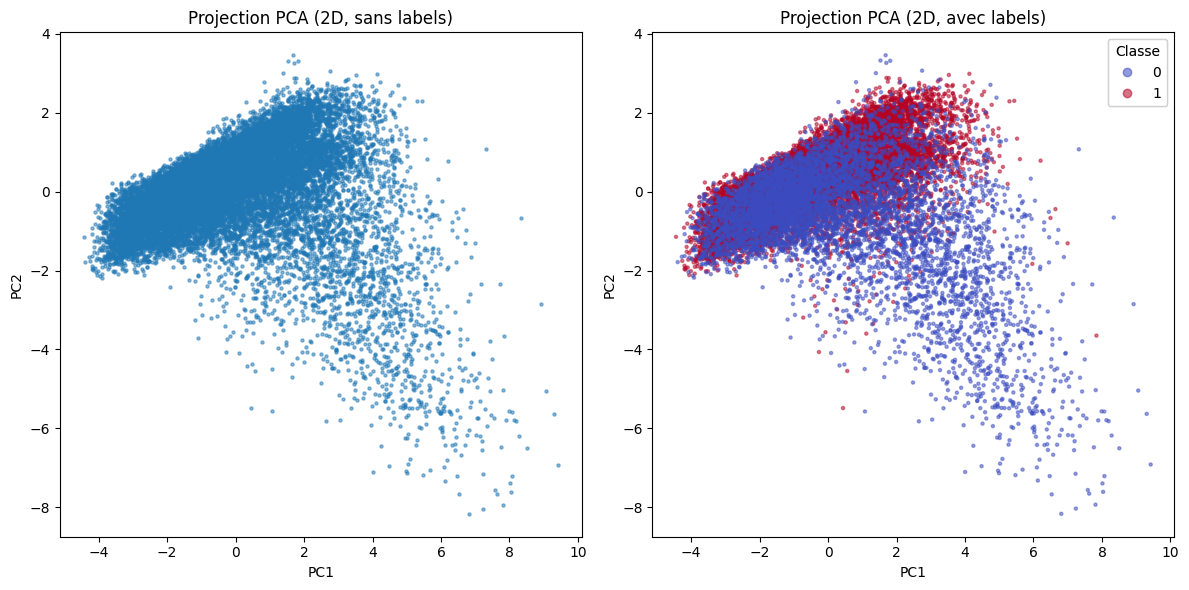

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- PCA 2D ---
X = df.drop(columns="class").values
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xz)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Sans labels
axes[0].scatter(X_pca[:,0], X_pca[:,1], s=5, alpha=0.5)
axes[0].set_title("Projection PCA (2D, sans labels)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Avec labels (gamma/hadron)
scatter = axes[1].scatter(X_pca[:,0], X_pca[:,1], c=(y=="g"), cmap="coolwarm", s=5, alpha=0.5)
axes[1].set_title("Projection PCA (2D, avec labels)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Légende pour labels
legend1 = axes[1].legend(*scatter.legend_elements(), title="Classe")
axes[1].add_artist(legend1)

plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

print("=== Distribution des classes ===")
print(df["class"].value_counts())

print("\n=== Proportions (%) ===")
print(df["class"].value_counts(normalize=True).round(3) * 100)

print("\n=== Aperçu du dataset ===")
display(df.head(10))

=== Distribution des classes ===
class
g    12332
h     6688
Name: count, dtype: int64

=== Proportions (%) ===
class
g    64.8
h    35.2
Name: proportion, dtype: float64

=== Aperçu du dataset ===


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,g
7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,g
8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,g
9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,g


## 2) Variantes de K-means dans scikit-learn (définitions)

### KMeans (avec initialisation **k-means++**)
- **Définition** : partitionne en `k` groupes en minimisant l’**inertie** (somme intra-cluster des carrés). L’initialisation `k-means++` choisit des centroïdes mieux espacés et accélère la convergence.  
- **Problème adressé** : **sensibilité à l’initialisation** (aléatoire) et convergence lente / solutions de mauvaise qualité ; `k-means++` rend l’algorithme plus stable et plus rapide. 
- **Hypothèses d’usage** : clusters **à variance similaire** et plutôt **isotropes** (distance euclidienne), données **mises à l’échelle**. 
- **API** : `KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0)`. 
---

### MiniBatchKMeans
- **Définition** : variante incrémentale qui met à jour les centroïdes à partir de **mini-lots** (sous-échantillons), au lieu de balayer tout `X` à chaque itération. :
- **Problème adressé** : **grands volumes** de données (mémoire/temps). Légère perte de précision vs KMeans, mais **beaucoup plus rapide** et **moins coûteux**.
- **Quand l’utiliser** : datasets très gros, répétitions nombreuses (plusieurs `k`, plusieurs redémarrages) ou contraintes mémoire
- **API** : `MiniBatchKMeans(n_clusters=k, random_state=0)`. 

---

### BisectingKMeans
- **Définition** : approche **hiérarchique descendante** : on commence à `k=2`, puis on **bifurque** itérativement un des clusters (souvent celui à plus forte inertie) jusqu’à obtenir `k` groupes. 
- **Problème adressé** : **manque de continuité** de KMeans quand `k` change (les partitions pour `k` et `k+1` n’héritent pas l’une de l’autre). BisectingKMeans produit une structure **plus régulière** et **interprétable** à grande échelle.
- **Quand l’utiliser** : besoin d’une **structure hiérarchique** ou d’une **trajectoire cohérente** des partitions quand on augmente `k`. 
- **API** : `BisectingKMeans(n_clusters=k, random_state=0)`.  



### Indicateurs d’évaluation du clustering

#### 1) Indicateurs internes (sans labels) 
Ils permettent surtout de **choisir le nombre de clusters k** et de comparer différents algorithmes sur la base de la compacité et de la séparation des groupes:
- **Inertia (SSE)** : Somme des distances au carré à l’intérieur des clusters.
C’est la fonction objectif par défaut de KMeans.
Plus c’est petit, mieux c’est.
Mais cela diminue toujours quand $k$ augmente, donc on l’utilise avec la « règle du coude ».
- **Silhouette coefficient** : Mesure la compacité d’un échantillon dans son cluster par rapport à la séparation avec le cluster le plus proche.
Valeurs entre [-1, 1].
Plus proche de 1, mieux c’est.
Souvent utilisé pour choisir $k$.  
- **Davies–Bouldin Index (DBI)** : Rapport entre la similarité inter-clusters et la compacité intra-cluster.
Plus c’est petit, mieux c’est.
Adapté pour comparer différents $k$ ou différents algorithmes. 
- **Calinski–Harabasz Index (CH)** : Rapport entre la dispersion inter-clusters et intra-clusters.
Plus c’est grand, mieux c’est.
Calcul rapide, souvent utilisé pour comparer rapidement. 

#### 2) Indicateurs externes (avec labels)
Ils ne servent pas à entraîner l’algorithme mais à **vérifier a posteriori** si la structure trouvée par le clustering correspond bien aux classes réelles.   :
- **Purity** : proportion d’éléments bien classés dans le cluster dominant. Entre 0 et 1.  
- **ARI (Adjusted Rand Index)** : compare les paires d’éléments dans les clusters vs. dans les vraies classes. Entre -1 et 1, 1 = partition parfaite.  
- **NMI (Normalized Mutual Information)** : mesure la similarité entre clustering et vraies classes. Entre 0 et 1.  


## 3) Choisir une variante de K-means et déterminer le nombre optimal de clusters *k*

Le jeu de données (19 020 × 10) n’est pas massif ; KMeans (k-means++) est une base solide (initialisation fiable, convergence rapide).  
Cependant, pour rester objectif, on évalue trois variantes sur une grille de *k* :  
**Procédure.**  
1) Standardiser les features (K-means est sensible aux échelles).  
2) Pour chaque variante et pour *k* ∈ {2,…,20} : entraîner, puis calculer Silhouette/DBI/CH/Inertia.  
3) Visualiser les courbes vs *k*（coude + Silhouette/DBI/CH）。  
4) Proposer un couple (**variante**, **k**) au meilleur compromis（Silhouette↑, DBI↓, CH↑；Inertia）。  
5) Si plusieurs variantes sont ex aequo, privilégier **KMeans (k-means++)**（simple, stable, reproductible）。



In [43]:
# --- Fabriques (constructeurs) par variante, paramétrées par k ---
def make_kmeans(k, random_state=0):
    return KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=random_state)

def make_minibatch(k, random_state=0):
    return MiniBatchKMeans(n_clusters=k, random_state=random_state)

def make_bisecting(k, random_state=0):
    return BisectingKMeans(n_clusters=k, random_state=random_state)

constructeurs = {
    "KMeans++":  make_kmeans,
    "MiniBatch": make_minibatch,
    "Bisecting": make_bisecting,
}

# --- Évaluation interne pour une variante sur une grille de k ---
def evaluer_variante(ctor, Xz, ks=range(2, 20)):
    """
    Retourne un DataFrame (k, silhouette, DBI, CH, inertia).
    """
    lignes = []
    for k in ks:
        model = ctor(k)
        labels = model.fit_predict(Xz)
        sil = silhouette_score(Xz, labels)
        dbi = davies_bouldin_score(Xz, labels)
        ch  = calinski_harabasz_score(Xz, labels)
        inertia = getattr(model, "inertia_", np.nan)  # Bisecting n'a pas cet attribut
        lignes.append({"k": k, "silhouette": sil, "DBI": dbi, "CH": ch, "inertia": inertia})
    return pd.DataFrame(lignes)
def choisir_k(df_scores):
    """
    Critère : maximiser Silhouette, puis minimiser DBI, puis maximiser CH.
    Renvoie: (k*, ligne)
    """
    key = lambda r: (r["silhouette"], -r["DBI"], r["CH"])
    best_idx = max(df_scores.index, key=lambda i: key(df_scores.loc[i]))
    return int(df_scores.loc[best_idx, "k"]), df_scores.loc[best_idx]

In [44]:
def tracer_courbes_combinees(scores_par_variante, titre="Comparaison des variantes (scores vs k)"):
    # --- Récupérer la grille de k (on prend celle du premier df) ---
    any_df = next(iter(scores_par_variante.values()))
    ks = any_df["k"].values

    # --- Préparer la figure : 2x2 sous-graphiques ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    ax = axes.ravel()

    # --- 1) Inertia (si disponible) ---

    has_inertia = all("inertia" in df.columns for df in scores_par_variante.values())
    if has_inertia:
        for nom, df in scores_par_variante.items():
            ax[0].plot(df["k"], df["inertia"], marker="o", label=nom)
        ax[0].set_title("Inertia (coude)")
        ax[0].set_xlabel("k"); ax[0].set_ylabel("SSE")
        ax[0].legend()
    else:
        ax[0].axis("off")  #

    # --- 2) Silhouette ---
    for nom, df in scores_par_variante.items():
        ax[1].plot(df["k"], df["silhouette"], marker="o", label=nom)
    ax[1].set_title("Silhouette (↑ mieux)")
    ax[1].set_xlabel("k"); ax[1].set_ylabel("score")
    ax[1].legend()

    # --- 3) DBI ---
    for nom, df in scores_par_variante.items():
        ax[2].plot(df["k"], df["DBI"], marker="o", label=nom)
    ax[2].set_title("Davies–Bouldin (↓ mieux)")
    ax[2].set_xlabel("k"); ax[2].set_ylabel("index")
    ax[2].legend()

    # --- 4) CH ---
    for nom, df in scores_par_variante.items():
        ax[3].plot(df["k"], df["CH"], marker="o", label=nom)
    ax[3].set_title("Calinski–Harabasz (↑ mieux)")
    ax[3].set_xlabel("k"); ax[3].set_ylabel("index")
    ax[3].legend()

    for a in ax:
        try:
            a.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        except Exception:
            pass

    fig.suptitle(titre, y=1.02)
    fig.tight_layout()
    plt.show()

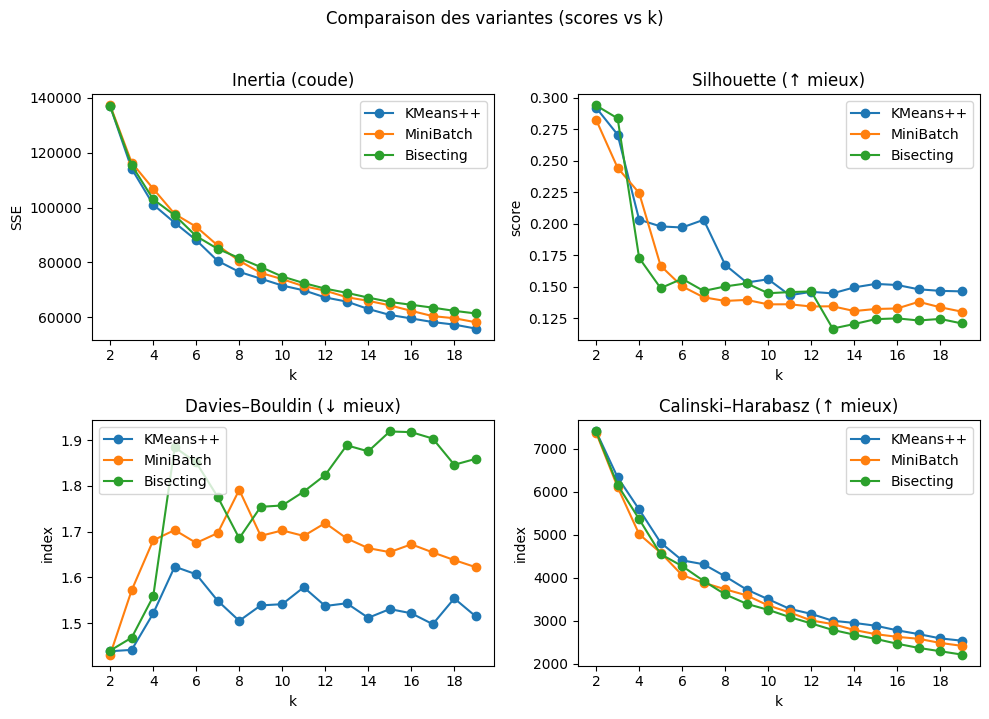

In [45]:
# --- Grille de k à tester ---
ks = range(2, 20)

# --- Évaluer chaque variante (mais ne pas tracer séparément) ---
scores_par_variante = {}
choix_par_variante = []

for nom, ctor in constructeurs.items():
    df_scores = evaluer_variante(ctor, Xz, ks)
    scores_par_variante[nom] = df_scores
    k_star, ligne = choisir_k(df_scores)
    choix_par_variante.append({
        "variante": nom, 
        "k": k_star,
        "silhouette": ligne["silhouette"],
        "DBI": ligne["DBI"], 
        "CH": ligne["CH"]
    })

# --- Tracer courbes comparées (fonction combinée) ---
tracer_courbes_combinees(scores_par_variante, "Comparaison des variantes (scores vs k)")

In [46]:
# for nom, df_scores in scores_par_variante.items():
#     print(f"\n=== Scores détaillés pour {nom} ===")
#     display(df_scores.round(4))

In [47]:
# --- Tableau récapitulatif des meilleurs choix par variante ---
recap = pd.DataFrame(choix_par_variante).sort_values(by=["silhouette","CH"], ascending=[False, False])
print("=== Meilleurs choix (par variante) ===")
display(recap.round(4))

=== Meilleurs choix (par variante) ===


,variante,k,silhouette,DBI,CH
2,Bisecting,2,0.2940,1.4400,7399.2146
0,KMeans++,2,0.2922,1.4386,7399.0142
1,MiniBatch,2,0.2826,1.4313,7371.8779


### Choix de la variante



In [48]:
# --- Règle de décision finale (simple et cohérente avec PCA) ---
final_variante = recap.iloc[0]["variante"]
final_k = int(recap.iloc[0]["k"])
print(f"Proposition finale : variante = {final_variante}, k = {final_k}")

Proposition finale : variante = Bisecting, k = 2


## Après optimisation des données

In [51]:
# === Sélection du meilleur couple (variante, k) à partir d'un récap ===
def choisir_meilleur(recap_df):
    recap_sorted = recap_df.sort_values(
        by=["silhouette", "DBI", "CH"],
        ascending=[False, True, True]
    ).reset_index(drop=True)
    variante_star = recap_sorted.loc[0, "variante"]
    k_star = int(recap_sorted.loc[0, "k"])
    return recap_sorted, variante_star, k_star

### 9D : suppression de fConc1 + tronquage des valeurs extrêmes (IQR) 

Dimensions (9D, sans fConc1, tronqué IQR) : (19020, 9)


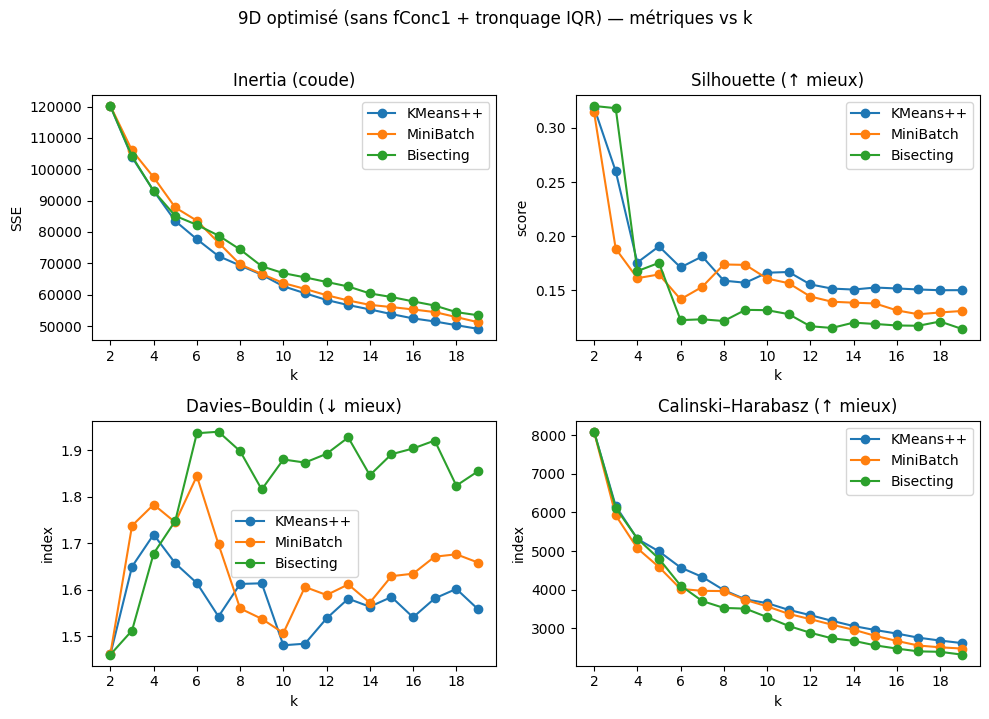

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Fonction utilitaire : tronquage (Winsorization) par IQR ---
def tronquer_iqr(df_numerique: pd.DataFrame, k: float = 1.5) -> pd.DataFrame:
    """
    Tronque chaque colonne numérique aux bornes [Q1 - k*IQR, Q3 + k*IQR].
    Cela limite l'influence des valeurs extrêmes tout en conservant toutes les lignes.
    """
    df_w = df_numerique.copy()
    for col in df_w.columns:
        q1, q3 = df_w[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        borne_basse = q1 - k * iqr
        borne_haute = q3 + k * iqr
        df_w[col] = df_w[col].clip(lower=borne_basse, upper=borne_haute)
    return df_w

# --- Préparation des données (version optimisée 9D) ---
# On enlève la colonne 'class' (labels) et la variable redondante fConc1,
# puis on tronque par IQR et on standardise.
X_9d_brut = df.drop(columns=["class", "fConc1"])
X_9d_tronque = tronquer_iqr(X_9d_brut, k=1.5)
X_9d_std = StandardScaler().fit_transform(X_9d_tronque)

print("Dimensions (9D, sans fConc1, tronqué IQR) :", X_9d_tronque.shape)

# --- Évaluation des variantes de K-means sur k ∈ [2..19] ---
scores_par_variante_9d = {}
choix_par_variante_9d = []

for nom_variante, constructeur in constructeurs.items():
    # calcule un DataFrame de scores internes pour tous les k
    df_scores = evaluer_variante(constructeur, X_9d_std, range(2, 20))
    scores_par_variante_9d[nom_variante] = df_scores

    # sélectionne le meilleur k pour cette variante (règle déjà définie dans choisir_k)
    k_opt, ligne_opt = choisir_k(df_scores)
    choix_par_variante_9d.append({
        "variante": nom_variante,
        "k": int(k_opt),
        "silhouette": float(ligne_opt["silhouette"]),
        "DBI": float(ligne_opt["DBI"]),
        "CH": float(ligne_opt["CH"])
        # l'inertie est déjà visualisée dans les courbes; on peut aussi l'ajouter au besoin
    })

# --- Tracé des 4 métriques internes (mêmes figures que dans ta version 10D) ---
# Cette fonction doit déjà exister dans ton notebook.
tracer_courbes_combinees(scores_par_variante_9d, 
                         "9D optimisé (sans fConc1 + tronquage IQR) — métriques vs k")



In [54]:
# --- Tableau récapitulatif : meilleur k par variante (version optimisée 9D) ---
print("=== Résultats avec 10D ===")
display(recap.round(4))

recap_9d = pd.DataFrame(choix_par_variante_9d)
print("=== Résultats (9D optimisé : sans fConc1 + tronquage IQR) ===")
display(recap_9d.round(4))


=== Résultats avec 10D ===


,variante,k,silhouette,DBI,CH
2,Bisecting,2,0.2940,1.4400,7399.2146
0,KMeans++,2,0.2922,1.4386,7399.0142
1,MiniBatch,2,0.2826,1.4313,7371.8779


=== Résultats (9D optimisé : sans fConc1 + tronquage IQR) ===


,variante,k,silhouette,DBI,CH
0,KMeans++,2,0.3188,1.4614,8086.1883
1,MiniBatch,2,0.3143,1.4628,8080.1218
2,Bisecting,2,0.3202,1.4609,8086.1457


In [55]:
# --- 10D (original) ---
recap_all_sorted, var_all, k_all = choisir_meilleur(recap)
print(f">>> Choix global 10D : variante = {var_all}, k = {k_all}")

# --- Sélection du meilleur couple (variante, k) au sein de la version 9D ---
recap_9d_tri, variante_9d, k_9d = choisir_meilleur(recap_9d)
print(f">>> Choix global 9D optimisé : variante = {variante_9d}, k = {k_9d}")


>>> Choix global 10D : variante = Bisecting, k = 2
>>> Choix global 9D optimisé : variante = Bisecting, k = 2


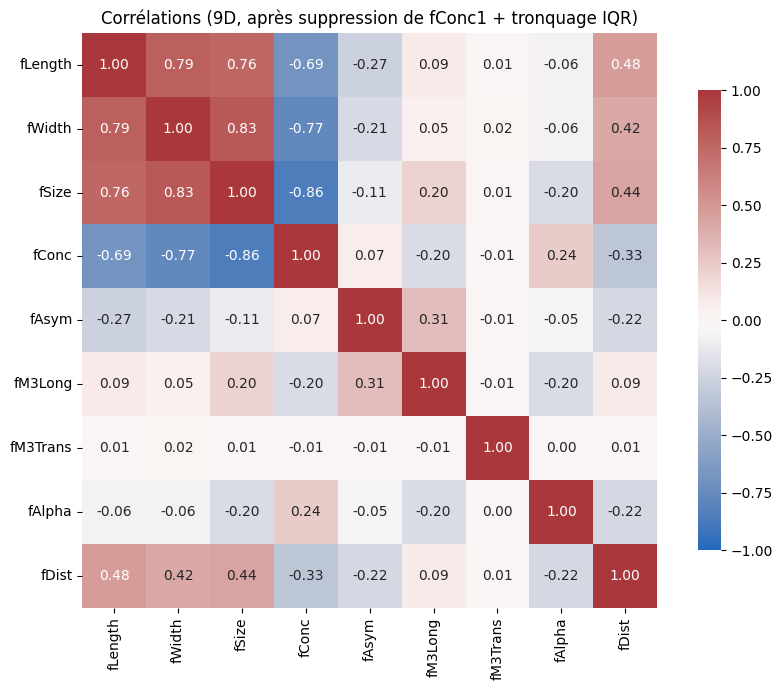

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

assert isinstance(X_9d_tronque, pd.DataFrame), "X_9d_tronque doit être un DataFrame"

corr = X_9d_tronque.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr, vmin=-1, vmax=1, cmap="vlag", annot=True, fmt=".2f",
    square=True, cbar_kws={"shrink": .8}
)
plt.title("Corrélations (9D, après suppression de fConc1 + tronquage IQR)")
plt.tight_layout()
plt.show()



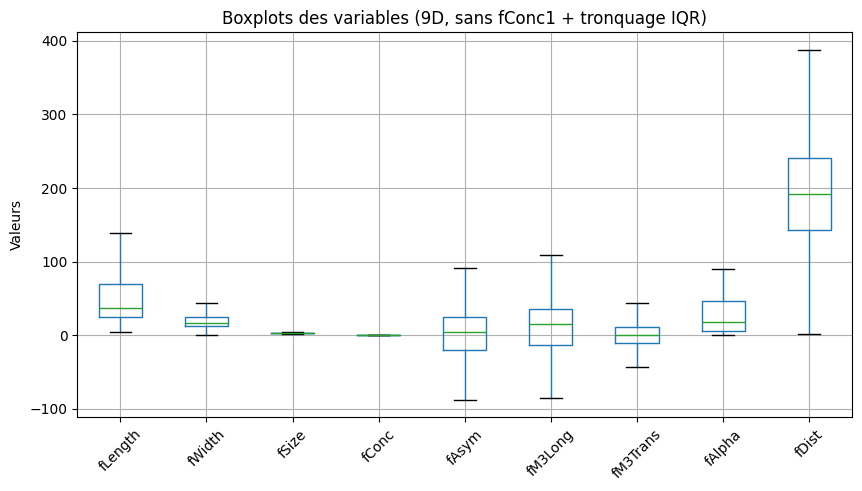

In [ ]:
plt.figure(figsize=(10,5))
X_9d_tronque.boxplot() 
plt.xticks(rotation=45)
plt.title("Boxplots des variables (9D, sans fConc1 + tronquage IQR)")
plt.ylabel("Valeurs")
plt.show()


## 4) Comparaison entre l’algorithme choisi et le K-means standard


### Comparaison sur 10D

In [ ]:
from sklearn.cluster import KMeans

k = final_k  

bk = BisectingKMeans(n_clusters=k, random_state=0).fit(Xz)
lab_bk = bk.labels_

km = KMeans(n_clusters=k, init="random", n_init=10, random_state=0).fit(Xz)
lab_km = km.labels_


In [59]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# --- Fonctions d’indicateurs ---
def purity_score(y_true, y_pred):
    cont = pd.crosstab(y_pred, y_true)
    return np.sum(np.max(cont.values, axis=1)) / np.sum(cont.values)

def eval_internes(X, labels, model, has_inertia=True):
    return {
        "Silhouette (↑)": silhouette_score(X, labels),
        "DBI (↓)": davies_bouldin_score(X, labels),
        "CH (↑)": calinski_harabasz_score(X, labels),
        "Inertia (↓)": getattr(model, "inertia_", None) if has_inertia else None
    }

def eval_externes(y_true, labels):
    return {
        "Purity (↑)": purity_score(y_true, labels),
        "ARI (↑)": adjusted_rand_score(y_true, labels),
        "NMI (↑)": normalized_mutual_info_score(y_true, labels)
    }

In [60]:
# --- Calcul des métriques (internes + externes) ---
res_bk = {**eval_internes(Xz, lab_bk, bk,), **eval_externes(y, lab_bk)}
res_km = {**eval_internes(Xz, lab_km, km),  **eval_externes(y, lab_km)}

comparaison = pd.DataFrame(
    [res_bk, res_km],
    index=[f"Bisecting (k={k})", f"KMeans std (k={k})"]
).round(4)

display(comparaison)

,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
Bisecting (k=2),0.294,1.44,7399.2146,136927.1351,0.6484,0.0065,0.0016
KMeans std (k=2),0.294,1.44,7399.2146,136927.1351,0.6484,0.0065,0.0016


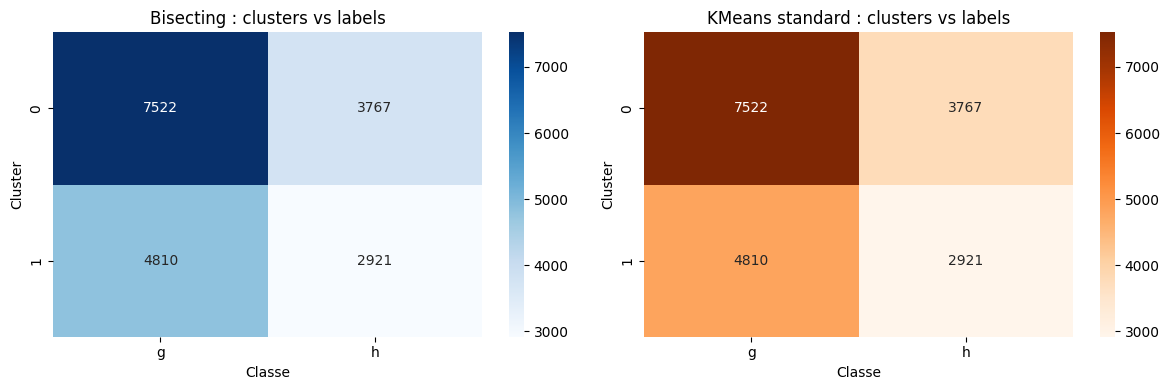

In [61]:
# --- Matrices de contingence (clusters vs labels) ---
cm_bk = pd.crosstab(lab_bk, y, rownames=["Cluster"], colnames=["Classe"])
cm_km = pd.crosstab(lab_km, y, rownames=["Cluster"], colnames=["Classe"])

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm_bk, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Bisecting : clusters vs labels")

sns.heatmap(cm_km, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("KMeans standard : clusters vs labels")

plt.tight_layout(); plt.show()

### Comparaison sur 9D AVEC tronquage (IQR)

=== Comparaison (9D tronqué IQR + standardisé) : Variante vs Standard ===


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
BisectingKMeans (k=2),0.3202,1.4609,8086.1457,120110.9979,0.6484,0.0215,0.0063
KMeans standard (k=2),0.3200,1.4610,8086.1873,120110.7377,0.6484,0.0213,0.0062


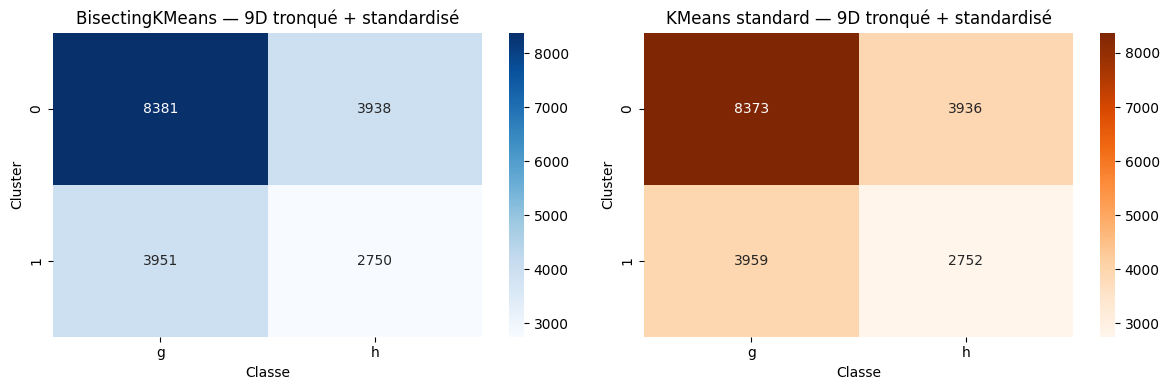

In [ ]:
from sklearn.cluster import KMeans, BisectingKMeans

# 1) Choix de k (reprend ton meilleur k déjà sélectionné)
k_9d_tronq = final_k if 'final_k' in globals() else k  # retombe sur k si final_k n'existe pas

# 2) Apprentissage sur 9D tronqué + standardisé
bk_9d_tronq = BisectingKMeans(n_clusters=k_9d_tronq, random_state=0).fit(X_9d_std)
lab_bk_9d_tronq = bk_9d_tronq.labels_

km_9d_tronq = KMeans(n_clusters=k_9d_tronq, init="random", n_init=10, random_state=0).fit(X_9d_std)
lab_km_9d_tronq = km_9d_tronq.labels_

# 3) Métriques internes + externes
res_bk_9d_tronq = {**eval_internes(X_9d_std, lab_bk_9d_tronq, bk_9d_tronq), **eval_externes(y, lab_bk_9d_tronq)}
res_km_9d_tronq = {**eval_internes(X_9d_std, lab_km_9d_tronq, km_9d_tronq), **eval_externes(y, lab_km_9d_tronq)}

comparaison_9d_tronq = pd.DataFrame(
    [res_bk_9d_tronq, res_km_9d_tronq],
    index=[f"BisectingKMeans (k={k_9d_tronq})", f"KMeans standard (k={k_9d_tronq})"]
).round(4)

print("=== Comparaison (9D tronqué IQR + standardisé) : Variante vs Standard ===")
display(comparaison_9d_tronq)

# 4) Matrices de contingence (clusters vs labels) pour visualiser l’alignement
cm_bk_9d_tronq = pd.crosstab(lab_bk_9d_tronq, y, rownames=["Cluster"], colnames=["Classe"])
cm_km_9d_tronq = pd.crosstab(lab_km_9d_tronq, y, rownames=["Cluster"], colnames=["Classe"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_bk_9d_tronq, annot=True, fmt="d", cmap="Blues",   ax=axes[0])
axes[0].set_title("BisectingKMeans — 9D tronqué + standardisé")

sns.heatmap(cm_km_9d_tronq, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("KMeans standard — 9D tronqué + standardisé")

plt.tight_layout()
plt.show()


## 5) Reprendre l’étude après réduction de dimension (ACP/PCA)



### PCA-2D sur 10D 

In [63]:
# --- PCA 2D ---
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2).fit(Xz)
X_pca2 = pca2.transform(Xz)

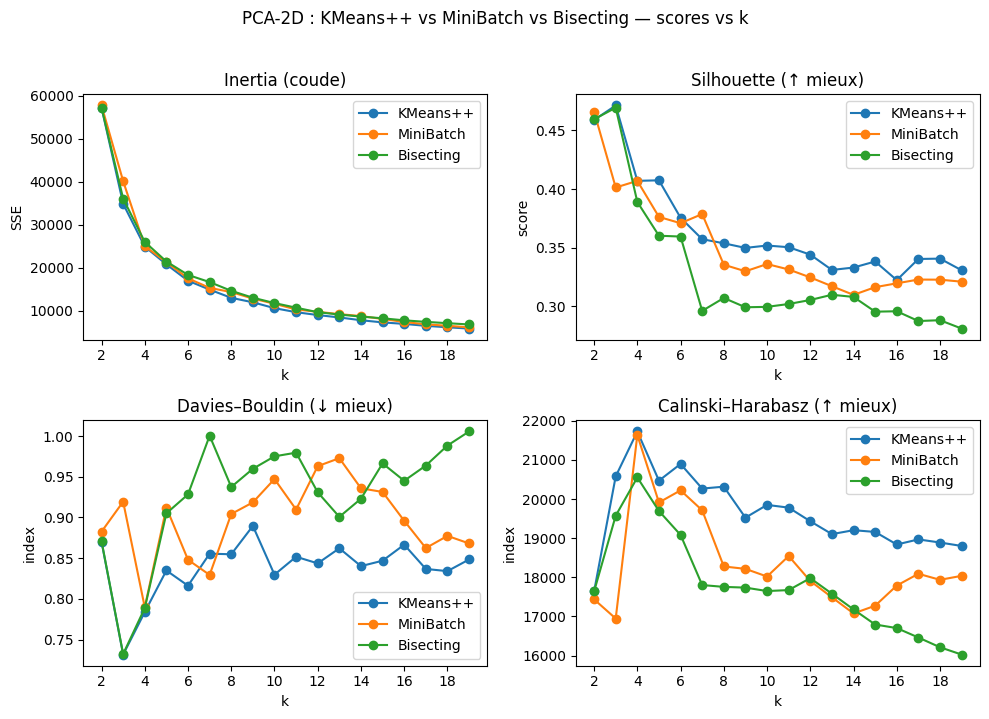

In [ ]:

ks = range(2, 20)

scores_par_variante_pca = {}
choix_par_variante_pca = []

for nom, ctor in constructeurs.items():       
    df_scores = evaluer_variante(ctor, X_pca2, ks) 
    scores_par_variante_pca[nom] = df_scores
    k_star, ligne = choisir_k(df_scores)         
    choix_par_variante_pca.append({
        "variante": nom,
        "k": int(k_star),
        "silhouette": ligne["silhouette"],
        "DBI": ligne["DBI"],
        "CH": ligne["CH"]
    })

tracer_courbes_combinees(scores_par_variante_pca, 
                         "PCA-2D : KMeans++ vs MiniBatch vs Bisecting — scores vs k")


In [65]:
import pandas as pd
best_by_variant_pca = pd.DataFrame(choix_par_variante_pca).rename(columns={
    "silhouette":"Silhouette (↑)", "DBI":"DBI (↓)", "CH":"CH (↑)"
})
display(best_by_variant_pca.round(4))


,variante,k,Silhouette (↑),DBI (↓),CH (↑)
0,KMeans++,3,0.4711,0.7317,20581.4634
1,MiniBatch,2,0.4658,0.8826,17436.6453
2,Bisecting,3,0.4692,0.7324,19575.8993


In [66]:
df_all_pca = []
for nom, df in scores_par_variante_pca.items():
    tmp = df.copy()
    tmp["variante"] = nom
    df_all_pca.append(tmp)
df_all_pca = pd.concat(df_all_pca, ignore_index=True)

df_all_pca["rank_key"] = list(zip(df_all_pca["silhouette"], -df_all_pca["DBI"], df_all_pca["CH"]))
best_row_idx = df_all_pca["rank_key"].idxmax()
meilleur_global_pca = df_all_pca.loc[best_row_idx].drop(labels="rank_key")
print("=== Meilleur (PCA-2D) ===")
display(meilleur_global_pca.to_frame().T.round(4))

=== Meilleur (PCA-2D) ===


,k,silhouette,DBI,CH,inertia,variante
1,3,0.471141,0.731718,20581.463402,34855.416875,KMeans++


In [67]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_pred, y_true)
    return np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

def eval_internes(Xin, labels, model):
    return {
        "Silhouette (↑)": silhouette_score(Xin, labels),
        "DBI (↓)": davies_bouldin_score(Xin, labels),
        "CH (↑)": calinski_harabasz_score(Xin, labels),
        "Inertia (↓)": getattr(model, "inertia_", None)
    }

def eval_externes(y_true, labels):
    return {
        "Purity (↑)": purity_score(y_true, labels),
        "ARI (↑)": adjusted_rand_score(y_true, labels),
        "NMI (↑)": normalized_mutual_info_score(y_true, labels)
    }

k = 3

# 1) KMeans++ dans PCA-2D
km_plus = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0).fit(X_pca2)
lab_plus = km_plus.labels_

# 2) KMeans standard (init aléatoire) dans PCA-2D
km_std = KMeans(n_clusters=k, init="random", n_init=10, random_state=0).fit(X_pca2)
lab_std = km_std.labels_

res_plus = {**eval_internes(X_pca2, lab_plus, km_plus), **eval_externes(y, lab_plus)}
res_std  = {**eval_internes(X_pca2, lab_std,  km_std),  **eval_externes(y, lab_std)}

comparaison_pca2 = pd.DataFrame([res_plus, res_std],
                                index=["KMeans++ (PCA-2D)", "KMeans std (PCA-2D)"]).round(4)

comparaison_pca2 = comparaison_pca2.rename(columns={
    "Silhouette (↑)":"Silhouette (↑)",
    "DBI (↓)":"DBI (↓)",
    "CH (↑)":"CH (↑)",
    "Inertia (↓)":"Inertia (↓)",
    "Purity (↑)":"Purity (↑)",
    "ARI (↑)":"ARI (↑)",
    "NMI (↑)":"NMI (↑)"
})
display(comparaison_pca2)


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
KMeans++ (PCA-2D),0.4711,0.7317,20581.4634,34855.4169,0.7158,0.0687,0.0932
KMeans std (PCA-2D),0.4707,0.7327,20581.8264,34855.0323,0.7162,0.0694,0.0934


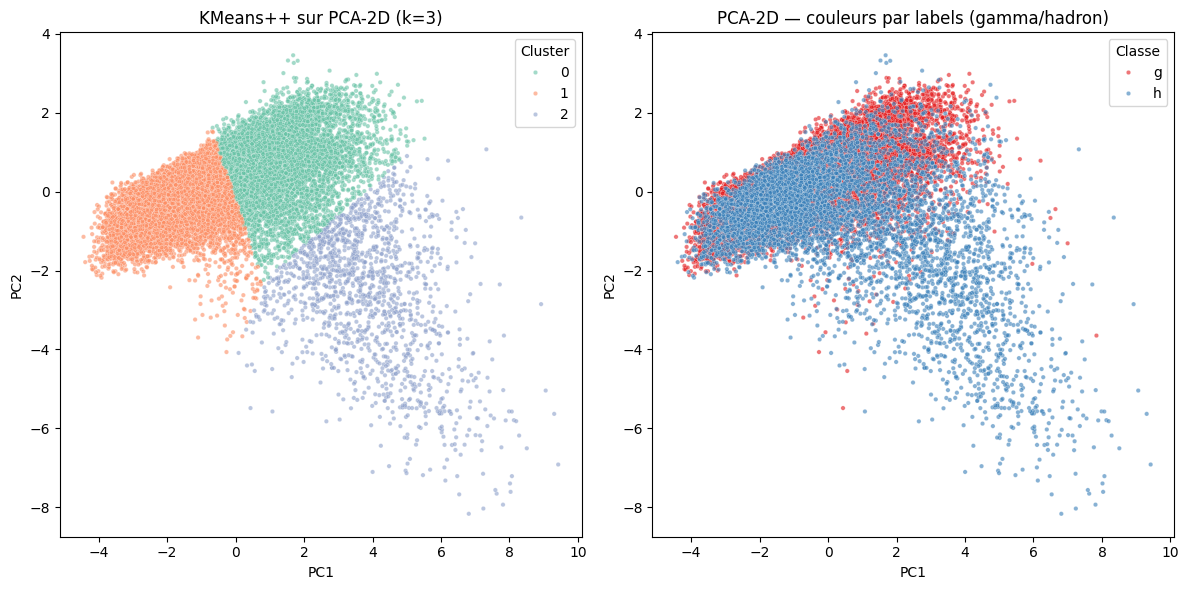

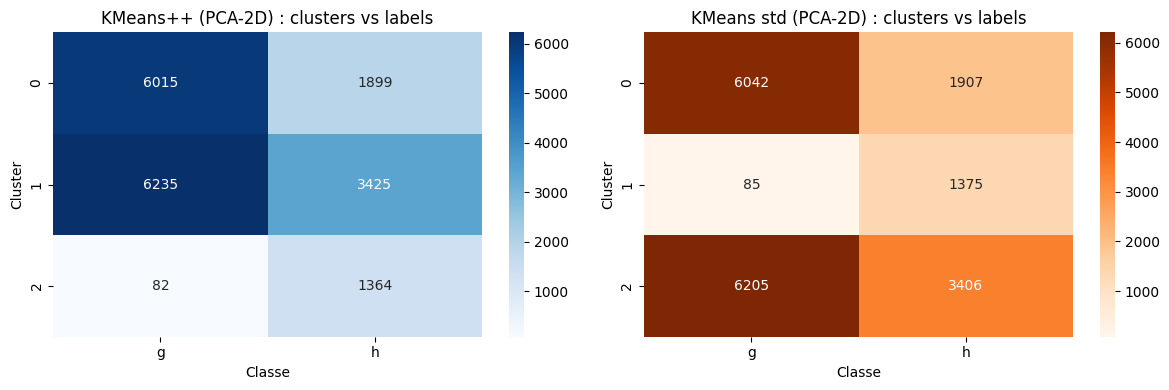

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(ax=axes[0], x=X_pca2[:,0], y=X_pca2[:,1],
                hue=lab_plus, palette="Set2", s=10, alpha=0.6, legend="full")
axes[0].set_title(f"KMeans++ sur PCA-2D (k={k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster")

sns.scatterplot(ax=axes[1], x=X_pca2[:,0], y=X_pca2[:,1],
                hue=y, palette="Set1", s=10, alpha=0.6, legend="full")
axes[1].set_title("PCA-2D — couleurs par labels (gamma/hadron)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
axes[1].legend(title="Classe")

plt.tight_layout()
plt.show()

cm_plus = pd.crosstab(lab_plus, y, rownames=["Cluster"], colnames=["Classe"])
cm_std  = pd.crosstab(lab_std,  y, rownames=["Cluster"], colnames=["Classe"])

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm_plus, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("KMeans++ (PCA-2D) : clusters vs labels")

sns.heatmap(cm_std, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("KMeans std (PCA-2D) : clusters vs labels")

plt.tight_layout()
plt.show()


### PCA-2D sur 9D (sans fConc1) + tronquage IQR

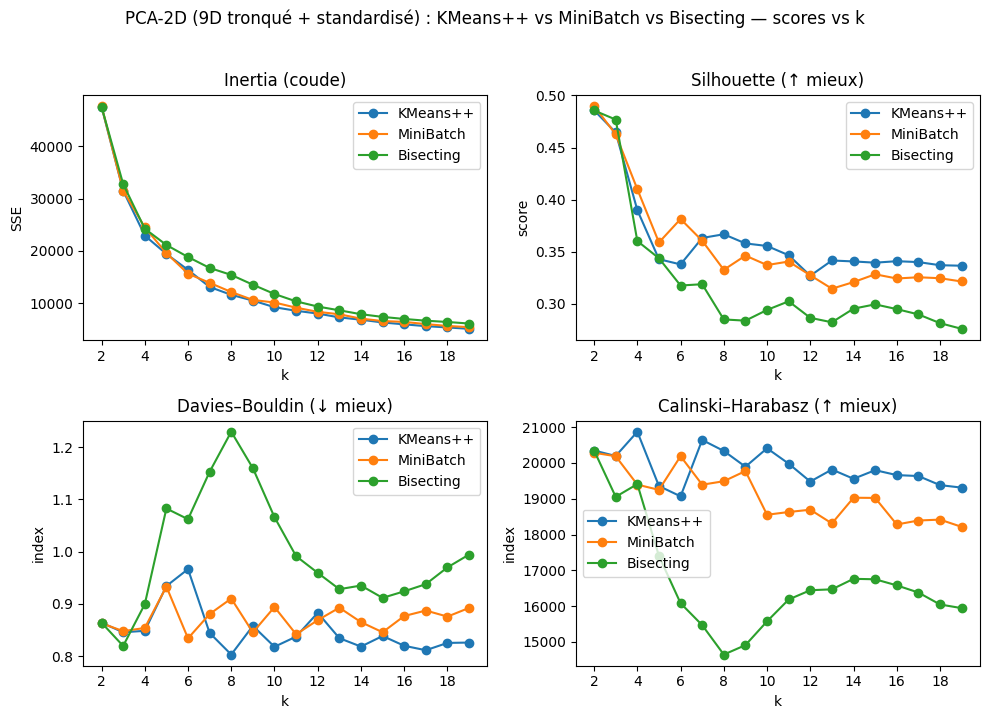

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


pca2_9d = PCA(n_components=2).fit(X_9d_std)
X_pca2_9d = pca2_9d.transform(X_9d_std)

ks = range(2, 20)

scores_par_variante_pca9d = {}
choix_par_variante_pca9d = []

for nom, ctor in constructeurs.items():
    df_scores = evaluer_variante(ctor, X_pca2_9d, ks)
    scores_par_variante_pca9d[nom] = df_scores
    k_star, ligne = choisir_k(df_scores)
    choix_par_variante_pca9d.append({
        "variante": nom,
        "k": int(k_star),
        "silhouette": ligne["silhouette"],
        "DBI": ligne["DBI"],
        "CH": ligne["CH"]
    })

tracer_courbes_combinees(
    scores_par_variante_pca9d,
    "PCA-2D (9D tronqué + standardisé) : KMeans++ vs MiniBatch vs Bisecting — scores vs k"
)


In [ ]:
best_by_variant_pca9d = pd.DataFrame(choix_par_variante_pca9d).rename(columns={
    "silhouette":"Silhouette (↑)", "DBI":"DBI (↓)", "CH":"CH (↑)"
})
print("=== Meilleurs par variante — PCA-2D (9D tronqué + standardisé) ===")
display(best_by_variant_pca9d.round(4))



=== Meilleurs par variante — PCA-2D (9D tronqué + standardisé) ===


,variante,k,Silhouette (↑),DBI (↓),CH (↑)
0,KMeans++,2,0.4857,0.8639,20348.6917
1,MiniBatch,2,0.4898,0.8629,20286.0101
2,Bisecting,2,0.4855,0.8640,20348.9304


In [ ]:
df_all_pca9d = []
for nom, df_ in scores_par_variante_pca9d.items():
    tmp = df_.copy()
    tmp["variante"] = nom
    df_all_pca9d.append(tmp)
df_all_pca9d = pd.concat(df_all_pca9d, ignore_index=True)

df_all_pca9d["rank_key"] = list(zip(df_all_pca9d["silhouette"], -df_all_pca9d["DBI"], df_all_pca9d["CH"]))
best_row_idx_9d = df_all_pca9d["rank_key"].idxmax()
meilleur_global_pca9d = df_all_pca9d.loc[best_row_idx_9d].drop(labels="rank_key")

print("=== Meilleur global — PCA-2D (9D tronqué + standardisé) ===")
display(meilleur_global_pca9d.to_frame().T.round(4))



=== Meilleur global — PCA-2D (9D tronqué + standardisé) ===


,k,silhouette,DBI,CH,inertia,variante
18,2,0.489837,0.86286,20286.010108,47711.354845,MiniBatch


In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans

k_pca9d = 2

mb_9d = MiniBatchKMeans(
    n_clusters=k_pca9d, random_state=0, batch_size=256, n_init="auto"
).fit(X_pca2_9d)
lab_mb_9d = mb_9d.labels_

km_std_9d = KMeans(
    n_clusters=k_pca9d, init="random", n_init=10, random_state=0
).fit(X_pca2_9d)
lab_std_9d = km_std_9d.labels_

res_mb_9d  = {**eval_internes(X_pca2_9d, lab_mb_9d,  mb_9d),  **eval_externes(y, lab_mb_9d)}
res_std_9d = {**eval_internes(X_pca2_9d, lab_std_9d, km_std_9d), **eval_externes(y, lab_std_9d)}

comparaison_pca2_9d = pd.DataFrame(
    [res_mb_9d, res_std_9d],
    index=[f"MiniBatchKMeans (PCA-2D/9D, k={k_pca9d})", f"KMeans standard (PCA-2D/9D, k={k_pca9d})"]
).round(4)

print("=== Comparaison MiniBatch vs KMeans std — PCA-2D (9D tronqué + standardisé) ===")
display(comparaison_pca2_9d)




=== Comparaison MiniBatch vs KMeans std — PCA-2D (9D tronqué + standardisé) ===


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
"MiniBatchKMeans (PCA-2D/9D, k=2)",0.4812,0.8653,20321.3247,47642.3094,0.6484,0.0148,0.0042
"KMeans standard (PCA-2D/9D, k=2)",0.4856,0.8640,20348.9088,47579.8657,0.6484,0.0185,0.0053


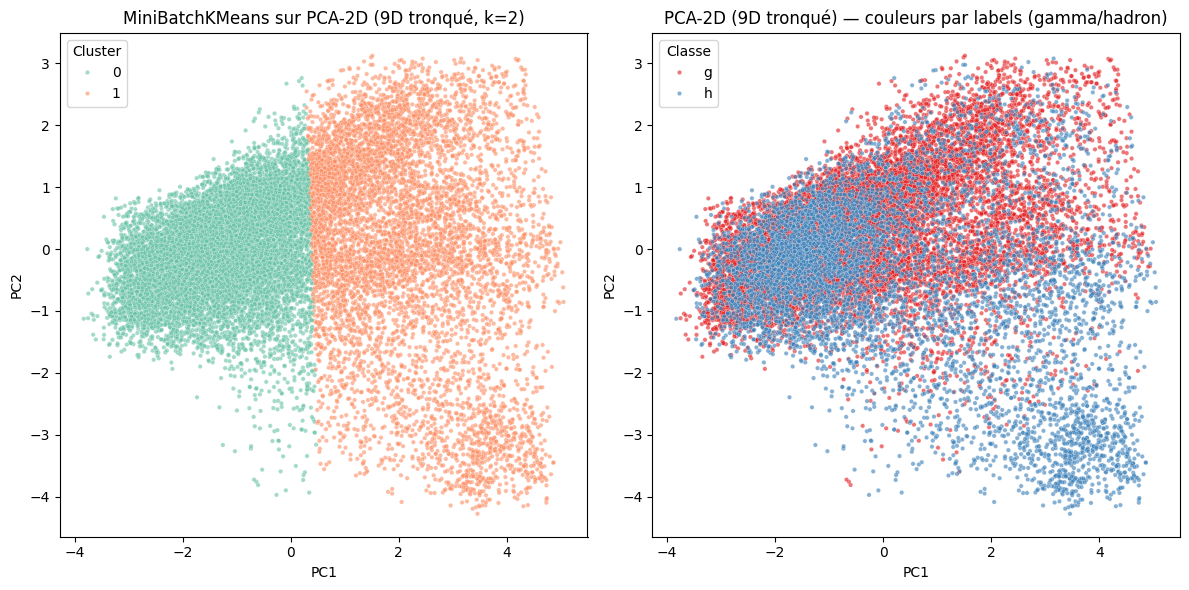

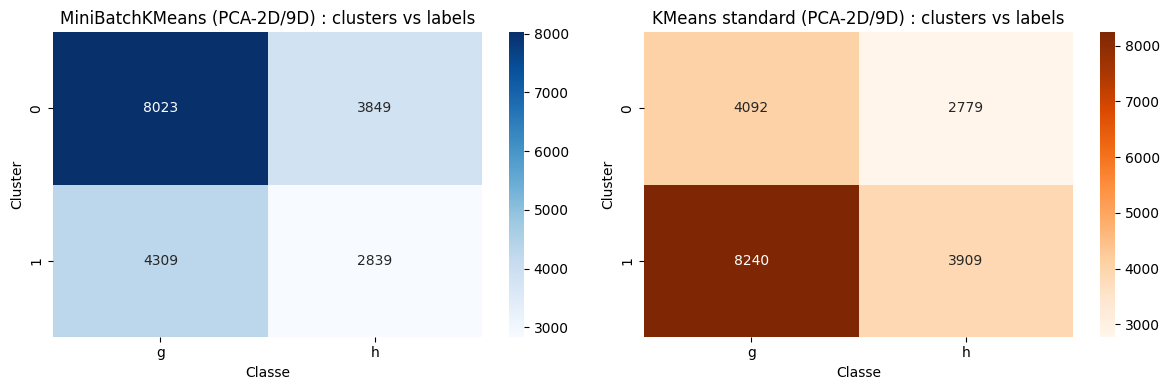

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(ax=axes[0], x=X_pca2_9d[:,0], y=X_pca2_9d[:,1],
                hue=lab_mb_9d, palette="Set2", s=10, alpha=0.6, legend="full")
axes[0].set_title(f"MiniBatchKMeans sur PCA-2D (9D tronqué, k={k_pca9d})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster")

sns.scatterplot(ax=axes[1], x=X_pca2_9d[:,0], y=X_pca2_9d[:,1],
                hue=y, palette="Set1", s=10, alpha=0.6, legend="full")
axes[1].set_title("PCA-2D (9D tronqué) — couleurs par labels (gamma/hadron)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
axes[1].legend(title="Classe")

plt.tight_layout()
plt.show()

cm_mb_9d  = pd.crosstab(lab_mb_9d,  y, rownames=["Cluster"], colnames=["Classe"])
cm_std_9d = pd.crosstab(lab_std_9d, y, rownames=["Cluster"], colnames=["Classe"])

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm_mb_9d,  annot=True, fmt="d", cmap="Blues",   ax=axes[0])
axes[0].set_title("MiniBatchKMeans (PCA-2D/9D) : clusters vs labels")

sns.heatmap(cm_std_9d, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("KMeans standard (PCA-2D/9D) : clusters vs labels")

plt.tight_layout()
plt.show()